In [1]:
!pip install shap

     |████████████████████████████████| 266kB 9.6MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376820 sha256=9d7dc12f2ab4889c2e85bd6a0a4520dd2b27277168a3d5a8290960d7e67ed1a4
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

Importa o dataset e retira colunas que não fazem diferença para a prediação do IDH

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving BRAZIL_CITIES.csv to BRAZIL_CITIES.csv
User uploaded file "BRAZIL_CITIES.csv" with length 2355728 bytes


In [5]:
# lista de cidades que não apresentam valor de IDH
lista = [("Pescaria Brava","SC"),
    ("Pinto Bandeira","RS"),
    ("Santa Terezinha","BA"),
    ("São Caetano","PE")]

# Atributos relevantes (Utilizado como método empírico na 1ª etapa, para
# mostrar a importancia de conhecher os dados)
atributos = ["CITY","STATE",
        "CAPITAL","IBGE_RES_POP",
        "IBGE_DU","IBGE_POP",
        "IBGE_60+","RURAL_URBAN",
        "GDP","MUN_EXPENDIT",
        "COMP_TOT","COMP_P",
        "COMP_Q","Cars",
        "Motorcycles", "IDHM"]

# importação do csv, considerando as colunas conveniêntes
data = pd.read_csv("BRAZIL_CITIES.csv",sep=";")

# Remoção das cidades da lista
data = data.set_index(["CITY","STATE"])
for objeto in lista:
    data = data.drop(objeto, axis=0)

# Recriação das colunas utilizadas para Indexar as linhas
data = data.reset_index()

data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 81 columns):
CITY                      5569 non-null object
STATE                     5569 non-null object
CAPITAL                   5569 non-null int64
IBGE_RES_POP              5564 non-null float64
IBGE_RES_POP_BRAS         5564 non-null float64
IBGE_RES_POP_ESTR         5564 non-null float64
IBGE_DU                   5562 non-null float64
IBGE_DU_URBAN             5562 non-null float64
IBGE_DU_RURAL             5491 non-null float64
IBGE_POP                  5564 non-null float64
IBGE_1                    5564 non-null float64
IBGE_1-4                  5564 non-null float64
IBGE_5-9                  5564 non-null float64
IBGE_10-14                5564 non-null float64
IBGE_15-59                5564 non-null float64
IBGE_60+                  5564 non-null float64
IBGE_PLANTED_AREA         5567 non-null float64
IBGE_CROP_PRODUCTION_$    5567 non-null float64
IDHM Ranking 2010         5565 no

Retira do dataset features com vários valores faltantes

In [6]:
#Retira colunas com muitos dados faltantes
data = data.drop(["REGIAO_TUR", "CATEGORIA_TUR", "HOTELS", "BEDS", "Pr_Agencies", "Pu_Agencies", "Pr_Bank","Pu_Bank",
               "Pr_Assets", "Pu_Assets", "UBER", "MAC", "WAL-MART", "MUN_EXPENDIT"], axis=1)

#Retira linhas com valores faltantes 
data.dropna(axis=0, how='any', inplace=True)
data = data.reset_index()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5368 entries, 0 to 5367
Data columns (total 68 columns):
index                     5368 non-null int64
CITY                      5368 non-null object
STATE                     5368 non-null object
CAPITAL                   5368 non-null int64
IBGE_RES_POP              5368 non-null float64
IBGE_RES_POP_BRAS         5368 non-null float64
IBGE_RES_POP_ESTR         5368 non-null float64
IBGE_DU                   5368 non-null float64
IBGE_DU_URBAN             5368 non-null float64
IBGE_DU_RURAL             5368 non-null float64
IBGE_POP                  5368 non-null float64
IBGE_1                    5368 non-null float64
IBGE_1-4                  5368 non-null float64
IBGE_5-9                  5368 non-null float64
IBGE_10-14                5368 non-null float64
IBGE_15-59                5368 non-null float64
IBGE_60+                  5368 non-null float64
IBGE_PLANTED_AREA         5368 non-null float64
IBGE_CROP_PRODUCTION_$    5368 non-

Mudando as variáveis categóricas para a classe "category" e a tornando a coluna AREA um valor numérico

In [7]:
data = data.astype({"STATE":'category', "GVA_MAIN": "category", "RURAL_URBAN":"category"})
data ['AREA'] = pd.to_numeric(data['AREA'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5368 entries, 0 to 5367
Data columns (total 68 columns):
index                     5368 non-null int64
CITY                      5368 non-null object
STATE                     5368 non-null category
CAPITAL                   5368 non-null int64
IBGE_RES_POP              5368 non-null float64
IBGE_RES_POP_BRAS         5368 non-null float64
IBGE_RES_POP_ESTR         5368 non-null float64
IBGE_DU                   5368 non-null float64
IBGE_DU_URBAN             5368 non-null float64
IBGE_DU_RURAL             5368 non-null float64
IBGE_POP                  5368 non-null float64
IBGE_1                    5368 non-null float64
IBGE_1-4                  5368 non-null float64
IBGE_5-9                  5368 non-null float64
IBGE_10-14                5368 non-null float64
IBGE_15-59                5368 non-null float64
IBGE_60+                  5368 non-null float64
IBGE_PLANTED_AREA         5368 non-null float64
IBGE_CROP_PRODUCTION_$    5368 no

In [0]:
data = data.drop(['AREA'], axis=1)

Pandas profiling do dataset para analise exploratória dos dados

In [9]:
pp.ProfileReport(data)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,67
Number of observations,5368
Total Missing (%),0.0%
Total size in memory,2.6 MiB
Average record size in memory,515.4 B
Numeric,17
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,45


Retirando as altas correlações e tirando outliers dos dados apontados pelo profiling. 

In [10]:
data_c = data.drop(["CITY", "IBGE_RES_POP_BRAS", "IBGE_RES_POP_ESTR", "IBGE_DU", "IBGE_DU_URBAN", "IBGE_POP", "IBGE_1", "IBGE_1-4", "IBGE_5-9", "IBGE_10-14",
                    "IBGE_15-59", "IBGE_60+", "IBGE_CROP_PRODUCTION_$", "IDHM_Renda", "IDHM_Educacao", "PAY_TV", "FIXED_PHONES", "ESTIMATED_POP", "GVA_SERVICES",
                    "GVA_PUBLIC", " GVA_TOTAL ", "TAXES", "GDP", "POP_GDP", "COMP_TOT", "COMP_C", "COMP_D", "COMP_E", "COMP_F", "COMP_G", "COMP_H", "COMP_I",
                    "COMP_J", "COMP_K", "COMP_L", "COMP_M", "COMP_N", "COMP_P", "COMP_Q", "COMP_R", "COMP_S", "COMP_T", "COMP_U", "Cars", "Motorcycles", "Wheeled_tractor",
                    "POST_OFFICES"], axis=1)

skewed = ["IBGE_RES_POP", "ALT", "GVA_INDUSTRY", "COMP_A", "COMP_B", "COMP_O"]

for column in skewed:
  iqr = data_c[column].quantile(0.75)-data_c[column].quantile(0.25)
  q = data_c[column].quantile(0.75) + 1.5*iqr
  data_c[column] = data_c[data_c[column] < q]
  data_c[column] = data_c[column].astype('float')

data_c.dropna(axis=0, how='any', inplace=True)

data_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 0 to 5367
Data columns (total 20 columns):
index                3382 non-null int64
STATE                3382 non-null category
CAPITAL              3382 non-null int64
IBGE_RES_POP         3382 non-null float64
IBGE_DU_RURAL        3382 non-null float64
IBGE_PLANTED_AREA    3382 non-null float64
IDHM Ranking 2010    3382 non-null float64
IDHM                 3382 non-null float64
IDHM_Longevidade     3382 non-null float64
LONG                 3382 non-null float64
LAT                  3382 non-null float64
ALT                  3382 non-null float64
RURAL_URBAN          3382 non-null category
GVA_AGROPEC          3382 non-null float64
GVA_INDUSTRY         3382 non-null float64
GDP_CAPITA           3382 non-null float64
GVA_MAIN             3382 non-null category
COMP_A               3382 non-null float64
COMP_B               3382 non-null float64
COMP_O               3382 non-null float64
dtypes: category(3), float64(15), 

Usando o One Hot Encoding para as variáveis categoricas

In [11]:
data_cc = pd.get_dummies(data_c, columns=["STATE","RURAL_URBAN", "GVA_MAIN"])
data_cc.head()

,index,CAPITAL,IBGE_RES_POP,IBGE_DU_RURAL,IBGE_PLANTED_AREA,IDHM Ranking 2010,IDHM,IDHM_Longevidade,LONG,LAT,ALT,GVA_AGROPEC,GVA_INDUSTRY,GDP_CAPITA,COMP_A,COMP_B,COMP_O,STATE_AC,STATE_AL,STATE_AM,STATE_AP,STATE_BA,STATE_CE,STATE_DF,STATE_ES,STATE_GO,STATE_MA,STATE_MG,STATE_MS,STATE_MT,STATE_PA,STATE_PB,STATE_PE,STATE_PI,STATE_PR,STATE_RJ,STATE_RN,STATE_RO,STATE_RR,STATE_RS,STATE_SC,STATE_SE,STATE_SP,STATE_TO,RURAL_URBAN_Intermediário Adjacente,RURAL_URBAN_Intermediário Remoto,RURAL_URBAN_Rural Adjacente,RURAL_URBAN_Rural Remoto,RURAL_URBAN_Urbano,"GVA_MAIN_Administração, defesa, educação e saúde públicas e seguridade social","GVA_MAIN_Agricultura, inclusive apoio à agricultura e a pós colheita",GVA_MAIN_Comércio e reparação de veículos automotores e motocicletas,GVA_MAIN_Construção,GVA_MAIN_Demais serviços,"GVA_MAIN_Eletricidade e gás, água, esgoto, atividades de gestão de resíduos e descontaminação",GVA_MAIN_Indústrias de transformação,GVA_MAIN_Indústrias extrativas,"GVA_MAIN_Pecuária, inclusive apoio à pecuária","GVA_MAIN_Produção florestal, pesca e aquicultura"
0,0,0,0.0,591.0,319.0,1689.0,0.708,0.830,-49.440548,-16.758812,0.0,6.20,0.0,20664.57,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,3,0,3.0,1027.0,1862.0,1994.0,0.698,0.848,-45.446191,-19.155848,3.0,113824.60,3.0,18250.42,3.0,3.0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
5,5,0,5.0,1540.0,2598.0,3522.0,0.628,0.748,-39.047547,-7.356977,5.0,4435.16,5.0,6370.41,5.0,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
6,6,0,6.0,1379.0,895.0,4086.0,0.603,0.746,-41.661608,-13.253532,6.0,12.41,6.0,6982.70,6.0,6.0,6.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
7,7,0,7.0,1953.0,2058.0,4756.0,0.575,0.776,-39.116588,-8.723418,7.0,9176.40,7.0,6256.80,7.0,7.0,7.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


Separa o dataset em treino e teste

In [0]:
X = data_cc.drop(["index", "IDHM_Longevidade", "IDHM Ranking 2010", "IDHM"], axis=1)
y = data_cc["IDHM"]

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, train_size=0.75, test_size=0.25)

Cria um pipeline para Scaling e redução de dimensionalidade (que não está funcionando)
Aplica o método de GridSearch para o escolher os melhores hiper parametros do random forest

In [23]:
parameters = {'n_estimators':[200, 300, 400, 500], 'max_depth':[5, 7, 9, 11]}
pipe = make_pipeline(StandardScaler(copy=False), PCA(n_components=15, copy=False)) 
pipe.fit_transform(X_treino, y_treino)

rfr = RandomForestRegressor(random_state=42)
model = GridSearchCV(rfr, param_grid=parameters, n_jobs=-1, cv=10)
model.fit(X_treino, y_treino)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 11],
      

Melhor modelo do Gridsearch e seu score de validação

In [24]:
print(model.best_estimator_)
print(model.best_score_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
0.8178414740995007


Score de teste

In [25]:
best_rfr = model.best_estimator_
best_rfr.fit(X_treino, y_treino)
best_rfr.score(X_teste, y_teste)

0.8177160642353899

Criando um set com as features_importances

In [26]:
set(zip(X_treino.columns, best_rfr.feature_importances_))

{('ALT', 0.0028995722915343123),
 ('CAPITAL', 0.0),
 ('COMP_A', 0.0027936085634053327),
 ('COMP_B', 0.0028647541545279874),
 ('COMP_O', 0.002982453893328753),
 ('GDP_CAPITA', 0.2326269458758335),
 ('GVA_AGROPEC', 0.02132593624409671),
 ('GVA_INDUSTRY', 0.002931425915739908),
 ('GVA_MAIN_Administração, defesa, educação e saúde públicas e seguridade social',
  0.0007494095018838787),
 ('GVA_MAIN_Agricultura, inclusive apoio à agricultura e a pós colheita',
  0.005498648219063857),
 ('GVA_MAIN_Comércio e reparação de veículos automotores e motocicletas',
  5.54866839013179e-05),
 ('GVA_MAIN_Construção', 1.5010788525576023e-05),
 ('GVA_MAIN_Demais serviços', 0.006565354092021409),
 ('GVA_MAIN_Eletricidade e gás, água, esgoto, atividades de gestão de resíduos e descontaminação',
  0.0003076895037033895),
 ('GVA_MAIN_Indústrias de transformação', 0.00018023009670009574),
 ('GVA_MAIN_Indústrias extrativas', 3.494996966627816e-05),
 ('GVA_MAIN_Pecuária, inclusive apoio à pecuária', 0.000461371

Levantando os valores SHAP para o modelo

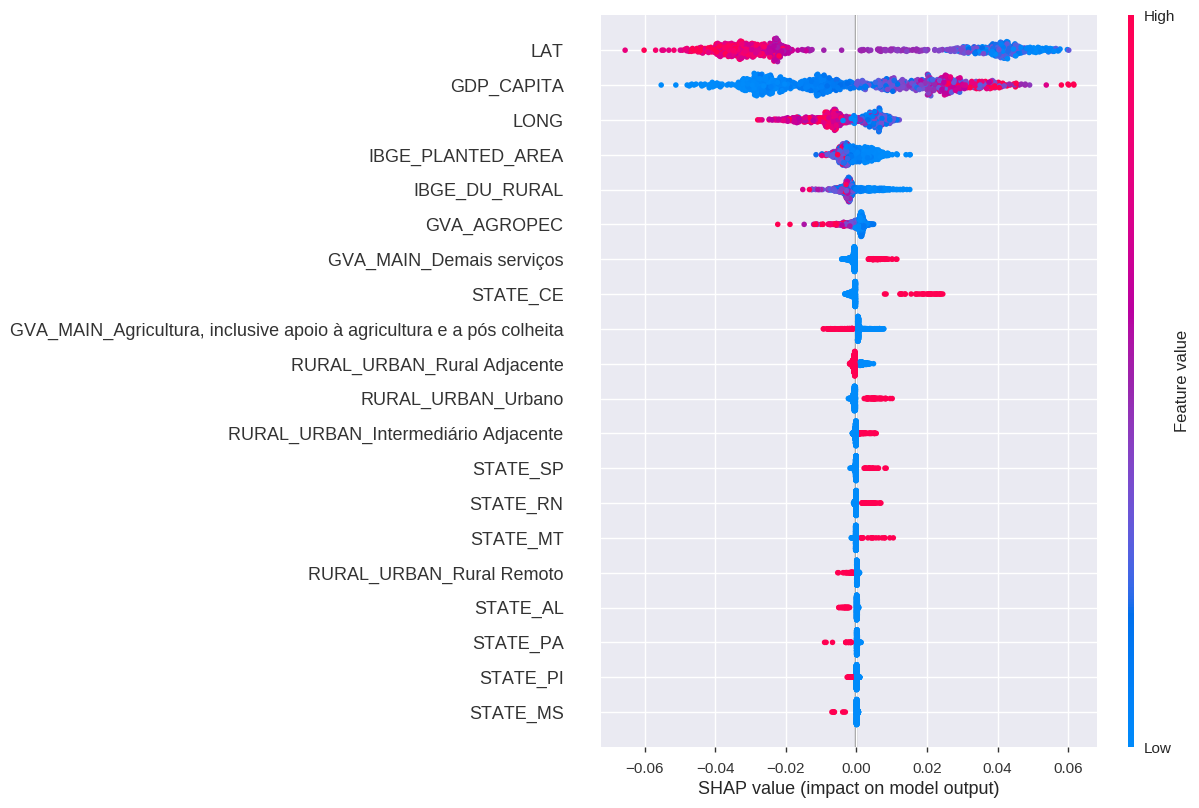

In [27]:
explainer = shap.TreeExplainer(best_rfr)
shap_values = explainer.shap_values(X_teste)
shap.summary_plot(shap_values, X_teste)

Aplicando o modelo sem as variáveis Latitude e Longitude

In [0]:
X2 = data_cc.drop(["index", "IDHM_Longevidade", "IDHM Ranking 2010", "IDHM", "LAT", "LONG"], axis=1)
y2 = data_cc["IDHM"]

X2_treino, X2_teste, y2_treino, y2_teste = train_test_split(X2, y2, train_size=0.75, test_size=0.25)

In [29]:
parameters2 = {'n_estimators':[200, 300, 400, 500], 'max_depth':[5, 7, 9, 11]}
pipe2 = make_pipeline(StandardScaler(copy=False), PCA(n_components=15, copy=False)) 
pipe2.fit_transform(X_treino, y_treino)

rfr2 = RandomForestRegressor(random_state=42)
model2 = GridSearchCV(rfr2, param_grid=parameters2, n_jobs=-1, cv=10)
model2.fit(X2_treino, y2_treino)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 11],
      

In [30]:
print(model2.best_estimator_)
print(model2.best_score_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
0.7486429119320865


In [31]:
best_rfr2 = model2.best_estimator_
best_rfr2.fit(X2_treino, y2_treino)
best_rfr2.score(X2_teste, y2_teste)

0.7657780106156533

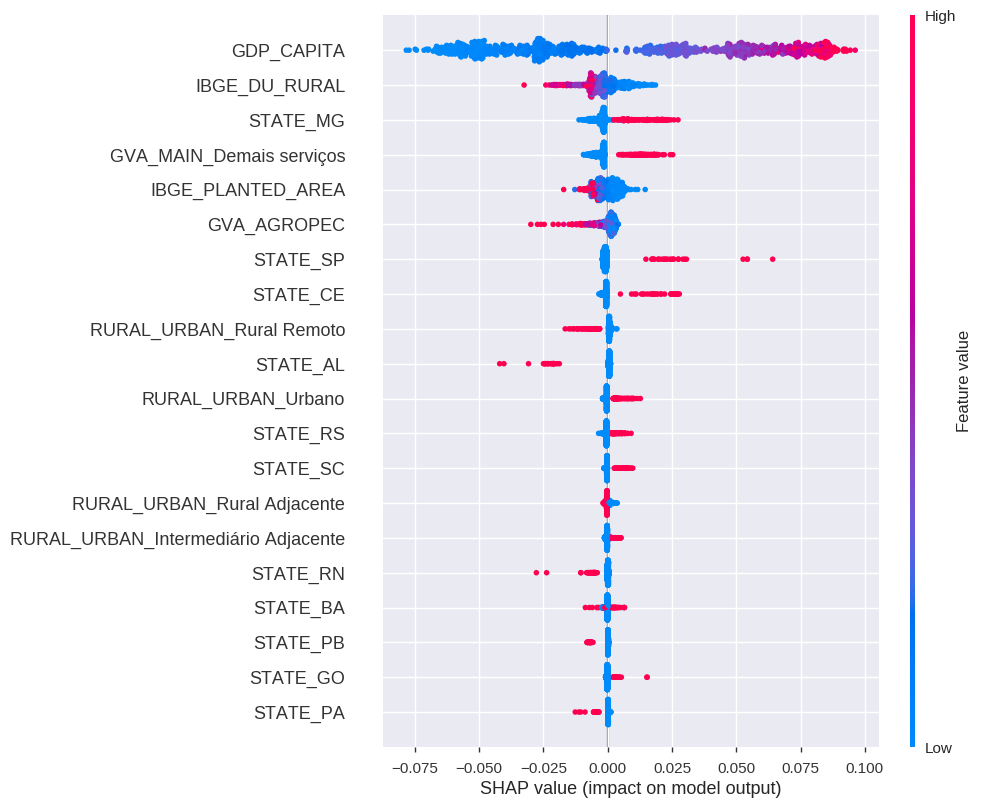

In [33]:
explainer2 = shap.TreeExplainer(best_rfr2)
shap_values2 = explainer2.shap_values(X2_teste)
shap.summary_plot(shap_values2, X2_teste)